In [15]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from skimage import io, transform
from matplotlib import pyplot as plt
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import os
plt.ion()   # interactive mode

In [16]:
print(torch.cuda.is_available())

True


In [17]:
# Load the test dataset and normalize it

data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/surface_quality'
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'),
                                          data_transforms['test'])
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                             shuffle=True, num_workers=4)
dataset_size = len(test_dataset)
class_names = test_dataset.classes

In [18]:
def test(model, epoch, criterion, data_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in data_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            model.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(data_loader) # loss function already averages over batch size
    acc = correct / len(data_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset), 100. * acc))
    return (acc, test_loss)

In [19]:
def imshow(batch, class_names=None, num_images=4):
    plt.figure(figsize=(1.7*num_images, 1.7))
    img, classes = batch
    img_num = min(num_images, img.shape[0])

    grid = torchvision.utils.make_grid(img[:img_num], nrow=img_num, padding=10, pad_value=10)
    grid = grid.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    if class_names:
        titles = [class_names[x] for x in classes[:img_num]]
        plt.title(titles)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [20]:
def visualize_model(model, dataset, class_names=None, num_images=6):
    inputs, target = next(iter(dataset))
    inputs, target = Variable(inputs), Variable(target)
    if torch.cuda.is_available():
        inputs, target = inputs.cuda(), target.cuda()
        model.cuda()
    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)
    imshow((inputs.data, preds), class_names=class_names, num_images=num_images)
    if class_names:
        print ('Actual labels:\n',[class_names[x] for x in target.data[:num_images]])
        

In [21]:
model = torch.load('pretrained/resnet18_surface.t7', map_location=lambda storage, loc: storage)

In [12]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [22]:
#Testing the cnn
criterion = nn.CrossEntropyLoss()
acc, loss = test(model, 0, criterion, dataloader)


Test set: Average loss: 0.0743, Accuracy: 136/140 (97%)



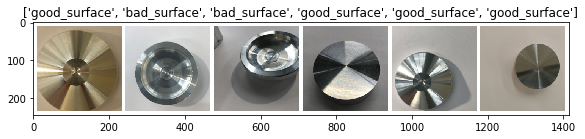

Actual labels:
 ['good_surface', 'bad_surface', 'bad_surface', 'good_surface', 'good_surface', 'good_surface']


In [23]:
visualize_model(model, dataloader, num_images=6, class_names=class_names)